## Reaction rate constant prediction
This file runs predicion of logK of X + OH reactions

## Import needed libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle
from ipynb.fs.full.Get_fingerprints import get_rdkit_fingerprint, get_cp_fingerprint
from ipynb.fs.full.Utils import plot_results, plot_arrhenius_params
from ipynb.fs.full.Evaluate import evaluate_model, cross_validate, run_ensamble
%matplotlib inline

## Load data from .csv  and calculate molecule features
Calls Data file to load data from .csv files. Full information on where the data comes from is found there. The target $k$ is in $cm^3 molec^{-1} s^{-1}$ units and is $log_{10}$ transformed. Then Get_fingerprints file is used to get Rdkit and chemprop features. More details available there.

In [2]:
df = pd.read_csv('./Data/df.csv')
df = df.join(get_rdkit_fingerprint(df))
cp_input = pd.read_csv('./Data/VOCensamble0.csv')
cp_features = cp_input.iloc[:,cp_input.columns != 'smiles']
df = df.join(cp_features,)
df

,Unnamed: 0,C.no,Compounds,smiles,InChi,InChiKey,Mwt,Atoms,Alternative Structure ID,Type,...,fp_1390,fp_1391,fp_1392,fp_1393,fp_1394,fp_1395,fp_1396,fp_1397,fp_1398,fp_1399
0,0,1.0,methane,C,InChI=1S/CH4/h1H4,VNWKTOKETHGBQD-UHFFFAOYSA-N,16.042460,CH4,NaN,1.0,...,0.0,0.103576,0.083245,0.240611,0.000000,0.000000,0.0,0.120855,0.0,0.0
1,1,2.0,formaldehyde,C=O,InChI=1S/CH2O/c1-2/h1H2,WSFSSNUMVMOOMR-UHFFFAOYSA-N,30.025980,CH2O,NaN,18.0,...,0.0,0.000000,0.000000,0.213487,0.000000,0.000000,0.0,0.000000,0.0,0.0
2,2,3.0,methanol,CO,"InChI=1S/CH4O/c1-2/h2H,1H3",OKKJLVBELUTLKV-UHFFFAOYSA-N,32.041860,CH4O,CH3-OH,16.0,...,0.0,0.529638,0.089407,0.000000,0.000000,0.067955,0.0,0.000000,0.0,0.0
3,3,4.0,fluoromethane,CF,InChI=1S/CH3F/c1-2/h1H3,NBVXSUQYWXRMNV-UHFFFAOYSA-N,34.032923,CH3F,CH3-F,60.0,...,0.0,0.251215,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
4,4,5.0,formic acid,OC=O,"InChI=1S/CH2O2/c2-1-3/h1H,(H,2,3)",BDAGIHXWWSANSR-UHFFFAOYSA-N,46.025380,CH2O2,HCO-OH,21.0,...,0.0,0.033004,0.000000,0.174890,0.201836,0.026386,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4478,4478,8.0,chloromethane,CCl,InChI=1S/CH3Cl/c1-2/h1H3,NEHMKBQYUWJMIP-UHFFFAOYSA-N,50.487520,CH3Cl,CH3-Cl,60.0,...,0.0,0.216427,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
4479,4479,8.0,chloromethane,CCl,InChI=1S/CH3Cl/c1-2/h1H3,NEHMKBQYUWJMIP-UHFFFAOYSA-N,50.487520,CH3Cl,CH3-Cl,60.0,...,0.0,0.216427,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
4480,4480,8.0,chloromethane,CCl,InChI=1S/CH3Cl/c1-2/h1H3,NEHMKBQYUWJMIP-UHFFFAOYSA-N,50.487520,CH3Cl,CH3-Cl,60.0,...,0.0,0.216427,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0
4481,4481,8.0,chloromethane,CCl,InChI=1S/CH3Cl/c1-2/h1H3,NEHMKBQYUWJMIP-UHFFFAOYSA-N,50.487520,CH3Cl,CH3-Cl,60.0,...,0.0,0.216427,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0


## Visualize dataset

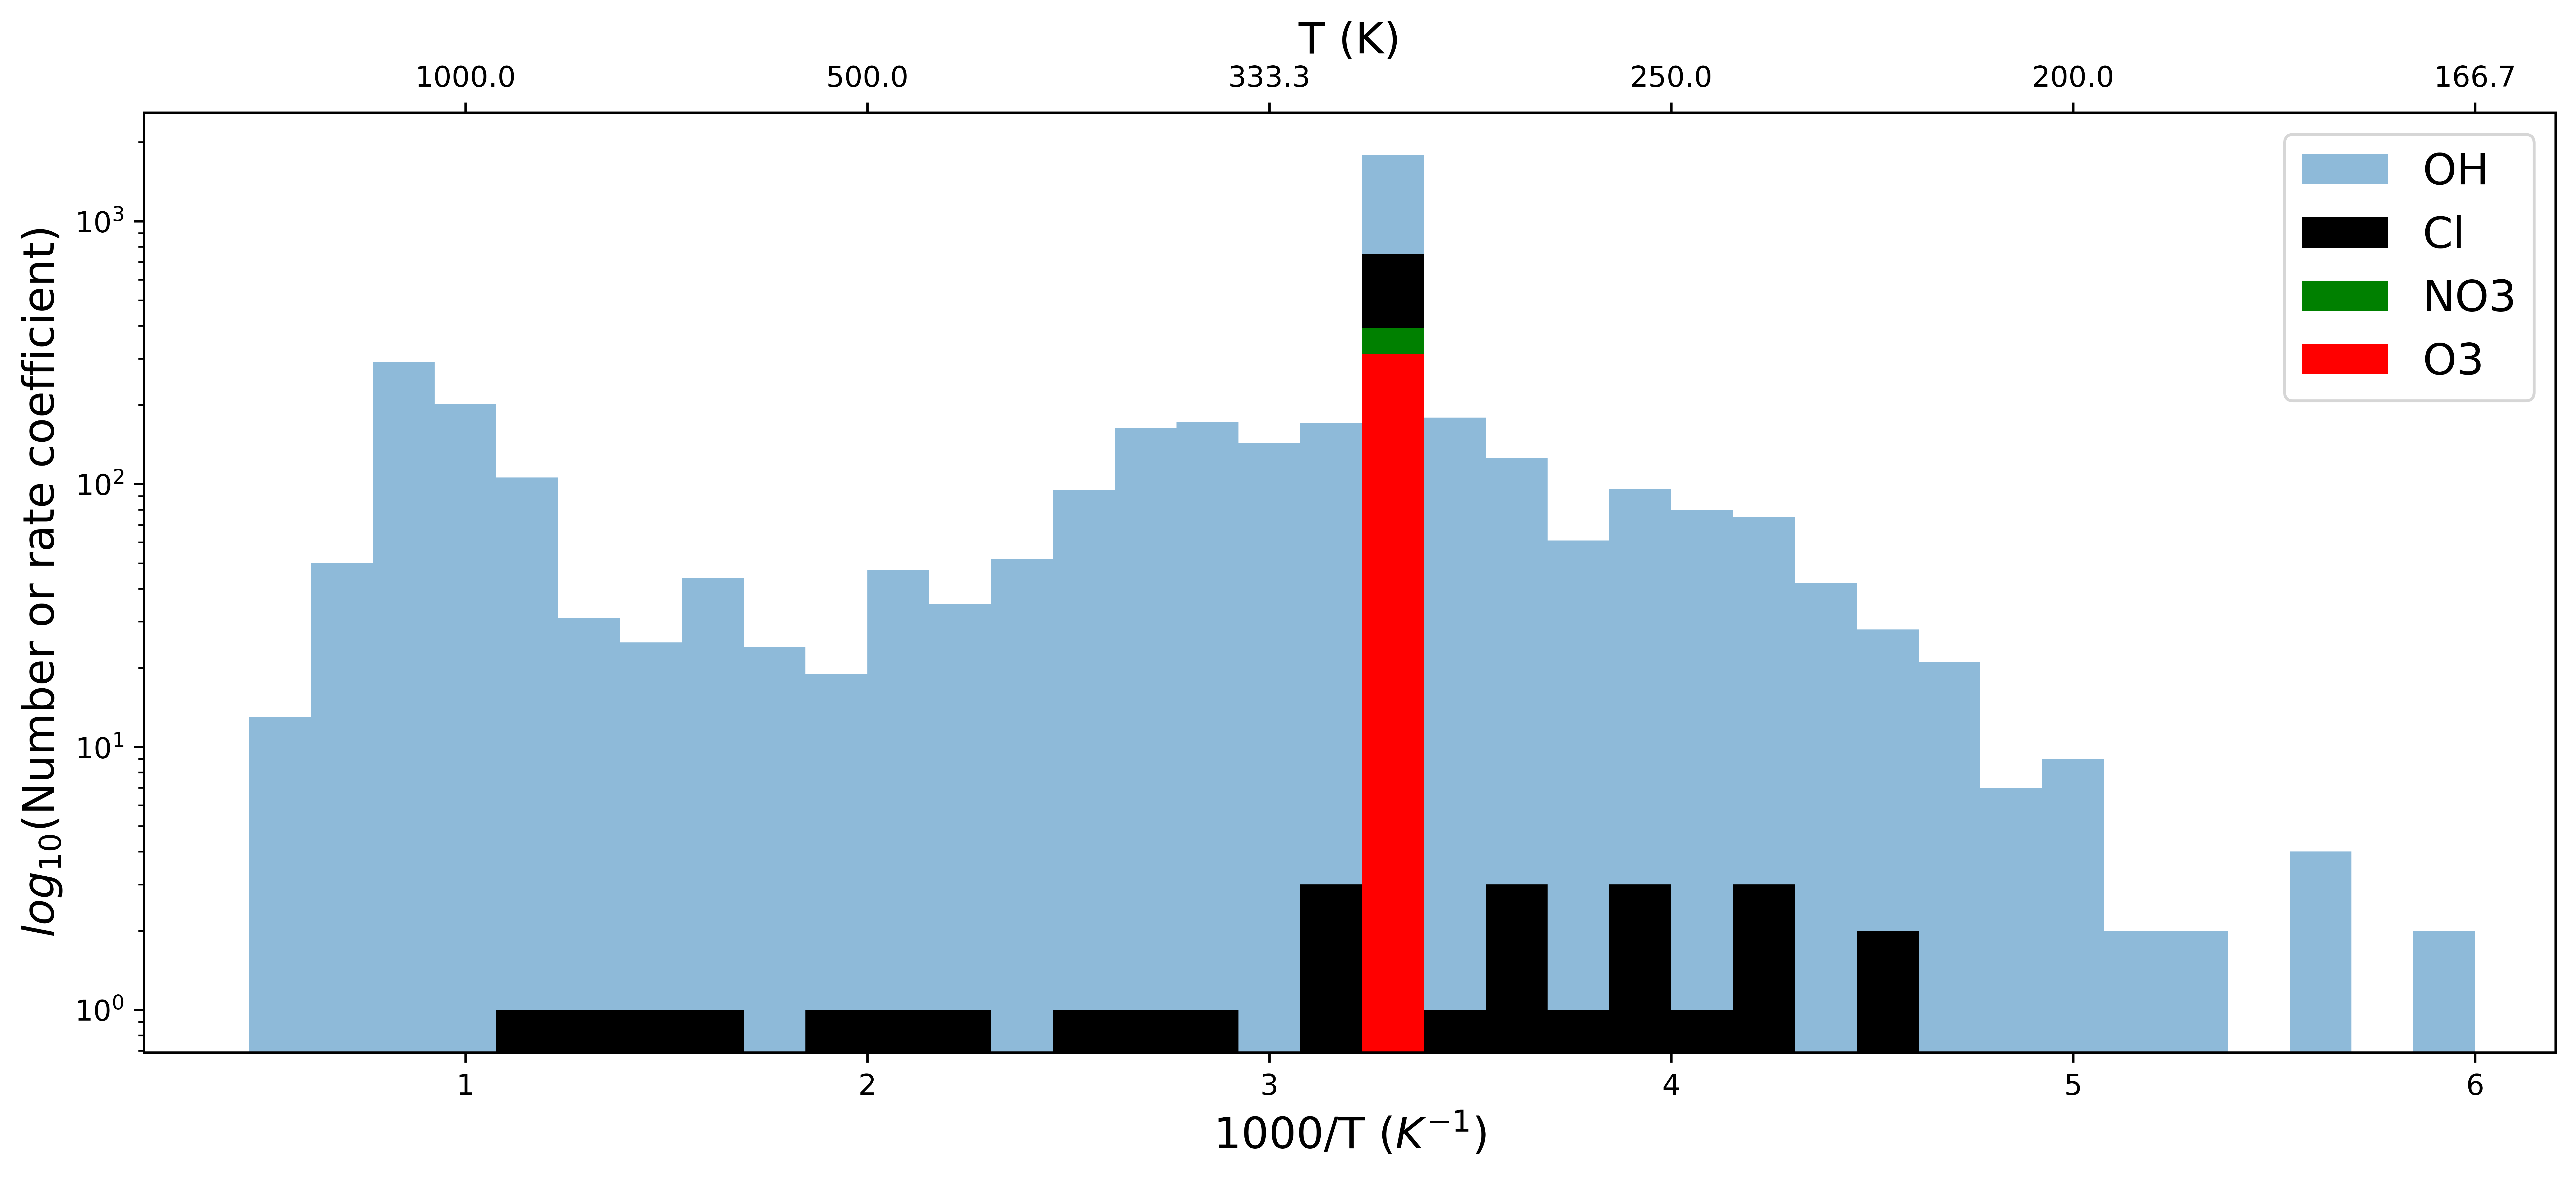

In [3]:
bins = np.linspace(0, 6, 40)
fig = plt.figure(figsize=(15, 6), dpi=800)
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
ax1.hist(1000/df[~df['oh_logK'].isnull()]['T'],bins=bins,histtype='bar',label='OH',alpha=0.5,log=True)
ax1.hist(1000/df[~df['cl_logK'].isnull()]['T'],bins=bins,color='black',histtype='bar',label='Cl',stacked=False)
ax1.hist(1000/df[~df['no3_logK'].isnull()]['T'],bins=bins,color='green',histtype='bar',label='NO3',stacked=False)
ax1.hist(1000/df[~df['o3_logK'].isnull()]['T'],bins=bins,color='red',histtype='bar',label='O3',stacked=False)
ax1.set_xlabel('1000/T ($K^{-1}$)',fontsize=15)
ax1.set_xlim([0.2,6.2])
ax1.set_ylabel('$log_{10}$(Number or rate coefficient)',fontsize=15)
ax1.legend(fontsize=15)
ax2.set_xlim(ax1.get_xlim())
ax2.set_xlabel('T (K)',fontsize=15)
ax2.set_xticks(ax1.get_xticks()[1:-1])
def tick_function(X):
    V = 1/(X/1000)
    return ["%.1f" % z for z in V]
ax2.set_xticklabels(tick_function(ax1.get_xticks()[1:-1]))
plt.show()

## Split to train(80%)/test(20%) sets
Split dataset randomly based on unique molecules

In [4]:
seed = 10
np.random.seed(seed)
unique = df['smiles'].unique()
K = int(unique.shape[0]*.2)
options_test = unique[np.random.choice(unique.shape[0],size=K,replace=False)]
train_mols = shuffle(df.loc[~df['smiles'].isin(options_test)])
test_mols  = df.loc[ df['smiles'].isin(options_test)]
print('Total of',unique.shape[0],'molecules and',df.shape[0],'data points')
print('Training on',unique.shape[0]-K, 'molecules and',train_mols.shape[0],'data points')
print('Testing on', K,'molecules and',test_mols.shape[0],'data points')

Total of 1587 molecules and 4483 data points
Training on 1270 molecules and 3480 data points
Testing on 317 molecules and 1003 data points


Visualize data split:

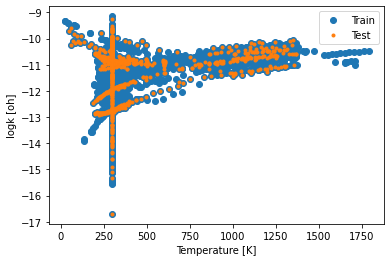

In [5]:
plt.plot(df['T'],df['oh_logK'],'o',label='Train')
plt.plot(test_mols['T'],test_mols['oh_logK'],'.',label='Test')
plt.xlabel('Temperature [K]')
plt.ylabel('logk [oh]')
plt.legend()

# Run example Arrhenius model:
First define model parameters

In [6]:
class param:
    split='Kfold'
    seed=10
    lr = 0.0003723
    hidden = [1500,1000,500]
    n_epochs = 200
    weights = [10,1,1,1]
    bweights = [1,1,1,1]
    scheduler_step = 500
    scheduler_gamma = 0.1
    batch_size =1024
    num_folds = 5
    input_type = 'All'
    model_type = 'Arrhenius'
    dropout = 0.2302
    scale_features = True
    scale_targets = True
    batch_norm = False
    target = 'Cl'
    teston = 'Cl'


## Perform 5-fold cross-validation
CV results on the Arrhenius loss model:

In [ ]:
l=cross_validate(train_mols,param)

Set Seed to 10
####### Evaluating fold 1 in a total of 5 folds #######
Epoch: 1 	Training Loss: MSE = 0.087100 ; RMSE = 0.295127
Epoch: 1 	Training A Loss: MSE = 0.011017 ; RMSE = 0.104961
Epoch: 1 	Training B Loss: MSE = 0.011014 ; RMSE = 0.104947
Epoch: 1 	Training n Loss: MSE = 0.010992 ; RMSE = 0.104841
Epoch: 1 	Training Arrhenius Loss: MSE = 0.005408 ; RMSE = 0.073537
Epoch: 1 	Validation Arrhenius Loss: MSE = 0.018225 ; RMSE = 0.135000
Epoch: 10 	Training Loss: MSE = 0.041258 ; RMSE = 0.203121
Epoch: 10 	Training A Loss: MSE = 0.004996 ; RMSE = 0.070680
Epoch: 10 	Training B Loss: MSE = 0.005021 ; RMSE = 0.070857
Epoch: 10 	Training n Loss: MSE = 0.010773 ; RMSE = 0.103793
Epoch: 10 	Training Arrhenius Loss: MSE = 0.002047 ; RMSE = 0.045242
Epoch: 10 	Validation Arrhenius Loss: MSE = 0.007731 ; RMSE = 0.087928
Epoch: 20 	Training Loss: MSE = 0.029315 ; RMSE = 0.171216
Epoch: 20 	Training A Loss: MSE = 0.004365 ; RMSE = 0.066069
Epoch: 20 	Training B Loss: MSE = 0.003341 ; RMSE =

Epoch: 1 	Training Loss: MSE = 0.080449 ; RMSE = 0.283634
Epoch: 1 	Training A Loss: MSE = 0.010227 ; RMSE = 0.101131
Epoch: 1 	Training B Loss: MSE = 0.010225 ; RMSE = 0.101118
Epoch: 1 	Training n Loss: MSE = 0.010204 ; RMSE = 0.101015
Epoch: 1 	Training Arrhenius Loss: MSE = 0.004979 ; RMSE = 0.070564
Epoch: 1 	Validation Arrhenius Loss: MSE = 0.024139 ; RMSE = 0.155368
Epoch: 10 	Training Loss: MSE = 0.037859 ; RMSE = 0.194574
Epoch: 10 	Training A Loss: MSE = 0.004474 ; RMSE = 0.066884
Epoch: 10 	Training B Loss: MSE = 0.004685 ; RMSE = 0.068449
Epoch: 10 	Training n Loss: MSE = 0.009951 ; RMSE = 0.099755
Epoch: 10 	Training Arrhenius Loss: MSE = 0.001875 ; RMSE = 0.043300
Epoch: 10 	Validation Arrhenius Loss: MSE = 0.011116 ; RMSE = 0.105431
Epoch: 20 	Training Loss: MSE = 0.029754 ; RMSE = 0.172492
Epoch: 20 	Training A Loss: MSE = 0.003691 ; RMSE = 0.060756
Epoch: 20 	Training B Loss: MSE = 0.003373 ; RMSE = 0.058075
Epoch: 20 	Training n Loss: MSE = 0.009493 ; RMSE = 0.097433


## Evaluate model

In [ ]:
Prediction = run_ensamble(options_test,param)